# Image Denoising Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a denoising model. For a given noisy image $X$, our model should learn to predict the denoised image $y$.


**Objectives**
- Visualize images
- Preprocess images for the neural network
- Fit a custom CNN for the task

## 1. Load Data

👉 Let's download the dataset archive.
It contains RGB and Black & White images we will be using for the rest of this challenge.

In [ ]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/paintings.zip > paintings.zip
! unzip -nq "paintings.zip" 
! rm "paintings.zip"
! ls -l

In [1]:
import glob
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset_paths = glob.glob("./paintings/*.jpg")
dataset_paths

['./paintings/Kazimir_Malevich_13.jpg',
 './paintings/Jan_van_Eyck_15.jpg',
 './paintings/Albrecht_Duâ\x95\xa0Ãªrer_34.jpg',
 './paintings/Edgar_Degas_271.jpg',
 './paintings/Titian_45.jpg',
 './paintings/Paul_Gauguin_65.jpg',
 './paintings/Andy_Warhol_89.jpg',
 './paintings/Pierre-Auguste_Renoir_151.jpg',
 './paintings/Pablo_Picasso_120.jpg',
 './paintings/Vincent_van_Gogh_305.jpg',
 './paintings/Pablo_Picasso_186.jpg',
 './paintings/Pablo_Picasso_63.jpg',
 './paintings/Albrecht_DuÌ\x88rer_244.jpg',
 './paintings/Frida_Kahlo_87.jpg',
 './paintings/Vincent_van_Gogh_558.jpg',
 './paintings/Pablo_Picasso_14.jpg',
 './paintings/Rene_Magritte_94.jpg',
 './paintings/El_Greco_63.jpg',
 './paintings/Gustav_Klimt_104.jpg',
 './paintings/Paul_Gauguin_12.jpg',
 './paintings/Vasiliy_Kandinskiy_57.jpg',
 './paintings/Edgar_Degas_228.jpg',
 './paintings/Marc_Chagall_101.jpg',
 './paintings/Pierre-Auguste_Renoir_57.jpg',
 './paintings/Leonardo_da_Vinci_50.jpg',
 './paintings/Rene_Magritte_50.jpg'

❓ **Display the image at index `53` of this dataset_paths (i.e the 54-th image)**

<details>
    <summary>Hint</summary>
    Use the <code>PIL.Image.open</code> and <code>matplotlib.pyplot.imshow</code> functions.
</details>

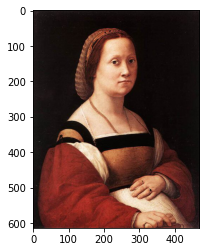

In [3]:
import imageio
im = imageio.imread(dataset_paths[53])
plt.imshow(im)

❓ **What is the shape of the image you displayed above `img_shape`?  How many dimensions `img_dim` does it have ?**

In [4]:
img_shape = im.shape
img_shape

(614, 469, 3)

In [5]:
img_dim = im.ndim
img_dim

3

❓ **What was in the image above?**

In [6]:
img_shape = img_shape
img_dim = img_dim

# Uncomment the correct answer

is_portrait = True
#is_portrait = False

is_colored_image = True
#is_colored_image = False

In [7]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    img_shape=img_shape,
    img_dim=img_dim,
    is_portrait=is_portrait,
    is_colored_image=is_colored_image
)

result.write()

## 2. Processing

❓ **Store all images from the dataset folder in a list of numpy arrays called `dataset_images`**

- It can take a while
- If the dataset is too big to fit in memory, just take the first half (or quarter) of all pictures

In [8]:
def get_images(paths):
    img_data = []
    for file in paths:
        img_data.append(imageio.imread(file))
    return np.array(img_data)

dataset_images = get_images(dataset_paths[:500])

### 2.1 Reshape, Resize, Rescale

Let's simplify our dataset and convert it to a single numpy array

❓ **First, check if that all the images in the dataset have the same number of dimensions**.
- What do you notice?
- How do you explain it? 

👉 We convert for you all black & white images into 3-colored ones by duplicating the image on three channels, so as to have only 3D arrays

In [9]:
dataset_images = [x if x.ndim==3 else np.repeat(x[:,:,None], 3, axis=2) for x in dataset_images]
set([x.ndim for x in dataset_images])

{3}

❓ **What about their shape now ?**
- Do they all have the same width/heights ? If not:
- Resize the images (120 pixels height and 100 pixels width) in the dataset, using `tensorflow.image.resize` function.
- Now that they all have the same shape, store them as a numpy array `dataset_resized`.
- This array should thus be of size $(n_{images}, 120, 100, 3)$

In [10]:
import tensorflow as tf

def resize(images):
    imgs=[]
    for im in images:
        resized_image = tf.image.resize(im, (120, 100))
        imgs.append(np.array(resized_image).astype('uint8'))
    return np.array(imgs)

dataset_images = resize(dataset_images)

In [11]:
np.stack(dataset_images).shape

(500, 120, 100, 3)

❓ **Rescale the data of each image between $0$ and $1$**
- Save your resulting list as `dataset_scaled`

In [12]:
dataset_scaled = dataset_images /255

### 2.2 Create (X,y) sets

👉 Now, we'll add for you some **random noise** to our images to simulate noise (that our model will try to remove later)

In [13]:
NOISE_LEVEL = 0.2

dataset_noisy = np.clip(
    dataset_scaled + np.random.normal(
        loc=0,
        scale=NOISE_LEVEL,
        size=dataset_scaled.shape
    ).astype(np.float32),
    0,
    1
)
dataset_noisy.shape

(500, 120, 100, 3)

❓ **Plot a noisy image below to visualize the noise and compare it with the normal one**

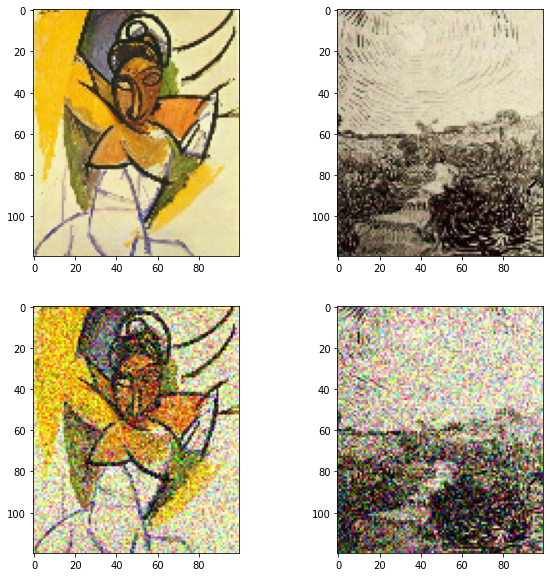

In [14]:
fig, ([[axis1, axis2],[axis3, axis4]]) = plt.subplots(2,2, figsize=(10,10))
axis1.imshow(dataset_scaled[10])
axis2.imshow(dataset_scaled[50])
axis3.imshow(dataset_noisy[10])
axis4.imshow(dataset_noisy[50])

❓ **Create your `(X_train, Y_train)`, `(X_test, Y_test)` training set for your problem**

- Remember you are trying to use "noisy" pictures in order to predict the "normal" ones.
- Keeping about `20%` of randomly sampled data as test set

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dataset_noisy, dataset_scaled, test_size=0.2)

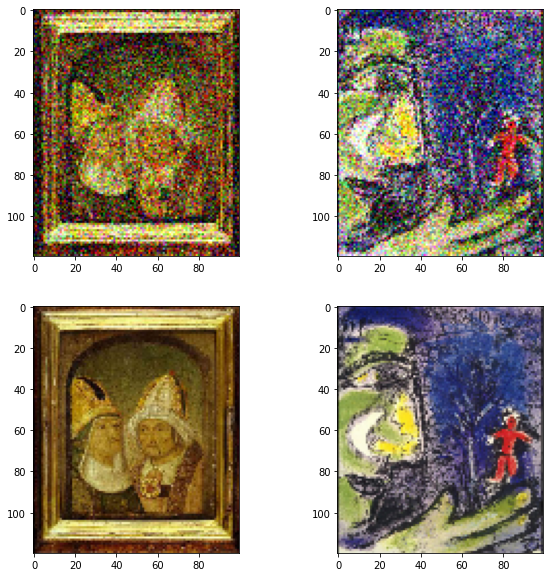

In [16]:
fig, ([[axis1, axis2],[axis3, axis4]]) = plt.subplots(2,2, figsize=(10,10))
axis1.imshow(X_train[0])
axis2.imshow(X_test[0])
axis3.imshow(Y_train[0])
axis4.imshow(Y_test[0])

In [17]:
from nbresult import ChallengeResult
result = ChallengeResult(
    "preprocessing",
    X_train_shape = X_train.shape,
    Y_train_shape = Y_train.shape,
    X_std = X_train[:,:,:,0].std(),
    Y_std = Y_train[:,:,:,0].std(),
    first_image = Y_train[0]
)
result.write()

## 3. Convolutional Neural Network

A commonly used neural network architecture for image denoising is the __AutoEncoder__.

<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

Its goal is to learn a compact representation of your data to reconstruct them as precisely as possible.  
The loss for such model must incentivize it to have __an output as close to the input as possible__.

For this challenge, __you will only be asked to code the Encoder part of the network__, since building a Decoder leverages layers architectures you are not familiar with (yet).

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)
    
! rm data_painting_solution.pickle
```

### 3.1 Architecture

👉 Run the cell below that defines the decoder

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Sequential

In [19]:
# We choose to compress images into a latent_dimension of size 6000
latent_dimensions = 6000

# We build a decoder that takes 1D-vectors of size 6000 to reconstruct images of shape (120,100,3)
decoder = Sequential(name='decoder')
decoder.add(layers.Reshape((30, 25, 8), input_dim=latent_dimensions))
decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 25, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 60, 50, 16)        1168      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 120, 100, 32)      4640      
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 100, 3)       867       
Total params: 6,675
Trainable params: 6,675
Non-trainable params: 0
_________________________________________________________________


❓ **Now, build the `encoder` that plugs correctly with the decoder defined above**. Make sure that:
- The output of your `encoder` is the same shape as the input of the `decoder`
- Use a convolutional neural network architecture without transfer learning
- Keep it simple
- Print model summary

In [20]:
latent_dimensions

6000

In [21]:
X_train[0].shape

(120, 100, 3)

In [62]:
inshape = X_train[0].shape

encoder = Sequential(name='encoder')

encoder.add(layers.Conv2D(input_shape=inshape ,filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
# encoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
encoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
encoder.add(layers.Flatten())
encoder.add(layers.Dense(latent_dimensions, activation='tanh'))

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 60, 50, 16)        448       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 50, 3)         435       
_________________________________________________________________
flatten_6 (Flatten)          (None, 9000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 6000)              54006000  
Total params: 54,006,883
Trainable params: 54,006,883
Non-trainable params: 0
_________________________________________________________________


👉 **Test your encoder below**

In [36]:
# HERE WE BUILD THE AUTO-ENCODER (ENCODER + DECODER) FOR YOU. IT SHOULD PRINT A NICE SUMMARY
from tensorflow.keras.models import Model

x = layers.Input(shape=(120, 100, 3))
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 100, 3)]     0         
_________________________________________________________________
encoder (Sequential)         (None, 6000)              54006883  
_________________________________________________________________
decoder (Sequential)         (None, 120, 100, 3)       6675      
Total params: 54,013,558
Trainable params: 54,013,558
Non-trainable params: 0
_________________________________________________________________


### 3.2 Training

❓ **Before training the autoencoder, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "stupid" case where you don't manage to de-noise anything at all.
- Store the result under `score_baseline`

In [46]:
score_baseline = np.mean(np.abs(Y_test - X_test))
score_baseline

0.13854027051090365

❓ Now, **train your autoencoder**

- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 5 minutes of training without GPUs.

In [72]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)

autoencoder.compile(loss='mse',
                   optimizer=opt,
                   metrics=['mae'])

autoencoder.fit(X_train, Y_train, 
          batch_size = 16,
          epochs=20,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/20
18/18 [==============================] - 15s 792ms/step - loss: 0.0522 - mae: 0.1669 - val_loss: 0.0429 - val_mae: 0.1614
Epoch 2/20
18/18 [==============================] - 16s 873ms/step - loss: 0.0230 - mae: 0.1157 - val_loss: 0.0399 - val_mae: 0.1509
Epoch 3/20
18/18 [==============================] - 25s 1s/step - loss: 0.0217 - mae: 0.1116 - val_loss: 0.0397 - val_mae: 0.1481
Epoch 4/20
18/18 [==============================] - 30s 2s/step - loss: 0.0194 - mae: 0.1043 - val_loss: 0.0369 - val_mae: 0.1444
Epoch 5/20
18/18 [==============================] - 30s 2s/step - loss: 0.0177 - mae: 0.0987 - val_loss: 0.0385 - val_mae: 0.1454
Epoch 6/20
18/18 [==============================] - 15s 837ms/step - loss: 0.0178 - mae: 0.0996 - val_loss: 0.0365 - val_mae: 0.1461
Epoch 7/20
18/18 [==============================] - 26s 1s/step - loss: 0.0173 - mae: 0.0982 - val_loss: 0.0371 - val_mae: 0.1432
Epoch 8/20
18/18 [==============================] - 33s 2s/step - loss: 0.0163 - 

❓ **Plot your training and validation loss at each epoch using the cell below**

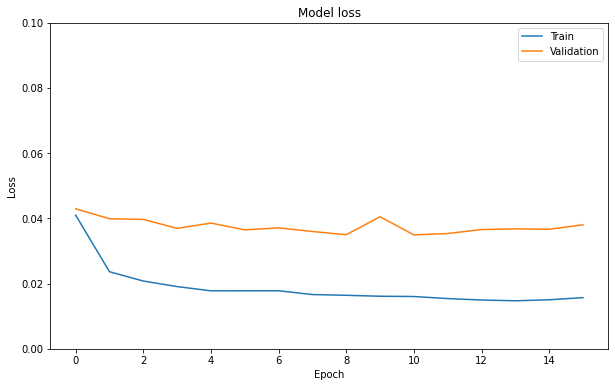

In [73]:
# Plot below your train/val loss history

fig = plt.figure(figsize=(10, 6))
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(ymin=0, ymax=0.1)
plt.legend(['Train', 'Validation'], loc='best')


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Evaluate your performances on test set**
- Compute your de-noised test set `Y_pred` 
- Store your test score as `score_test`
- Plot a de-noised image from your test set and compare it with the original and noisy one using the cell below

In [68]:
Y_pred = autoencoder.predict(X_test)
score_test = np.mean(np.abs(Y_test - Y_pred))
score_test

0.13435092675758167

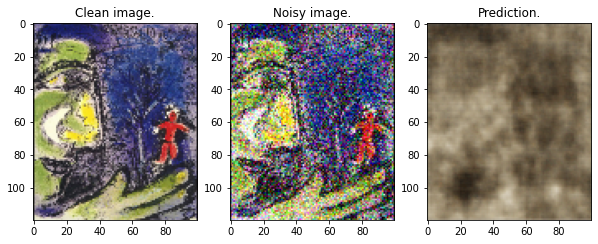

In [74]:
# RUN THIS CELL TO CHECK YOUR RESULTS
idx = 0

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(Y_test[idx])
axs[0].set_title("Clean image.")

axs[1].imshow(X_test[idx])
axs[1].set_title("Noisy image.")

axs[2].imshow(Y_pred[idx])
axs[2].set_title("Prediction.")

# Run this to save your results for correction
plt.savefig('tests/image_denoised.png')

🧪 **Send your results below**

In [70]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    input_shape = list(encoder.input.shape),
    output_shape = list(encoder.output.shape),
    layer_names = [layer.name for layer in encoder.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in encoder.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()